In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
import copy
import os
import pprint
import itertools

import hydra
from omegaconf import OmegaConf
from einops import rearrange
import numpy as np
import pandas as pd
import seaborn as sns
font_scale=2.5
sns.set_theme(style='white', font_scale=font_scale, palette=sns.color_palette('Set2'),)
import matplotlib.pyplot as plt
import matplotlib
import sqlalchemy as sa
import marimo as mo
import seaborn as sns
import lightning.pytorch
import polars as pl
from tqdm import tqdm
import duckdb

from conf import conf
from dafm import datasets, models, plots, utils

In [3]:
engine = conf.get_engine()
session = conf.sa.orm.Session(engine)
session.begin()

In [4]:
duckdb.sql("""
attach '../runs.sqlite';
use runs;
""")

In [5]:
variable_name = 'Ensemble size'
def variable(cfg):
    return pl.lit(cfg.dataset.predicted_state_count).alias(variable_name)
alt_ids = pl.DataFrame(
    orient='row',
    schema=[
        'alt_id', 'label',
    ],
    data=[
        # NS64
        # ['4srgdpm4', 'EnSF'],
        # ['0p1026zg', 'EnFF-OT'],
        # ['u89qfmjc', 'EnFF-F2P'],
        # NS256
        ['ej8k2ukr', 'EnSF'],
        ['n20svo99', 'EnFF-OT'],
        ['dtewzrcv', 'EnFF-F2P'],
    ],
)
alt_ids = duckdb.sql("""
select
    alt_ids.*,
    rng_seed
from alt_ids
join Conf on Conf.alt_id = alt_ids.alt_id
""").pl()
alt_ids

alt_id,label,rng_seed
str,str,i64
"""n20svo99""","""EnFF-OT""",97616566
"""dtewzrcv""","""EnFF-F2P""",97616566
"""ej8k2ukr""","""EnSF""",97616566


In [6]:
cfgs = session.execute(sa.select(conf.Conf).where(conf.Conf.alt_id.in_(alt_ids.get_column('alt_id'))))
cfgs = {c.alt_id: c for (c,) in cfgs}
cfgs = {k: {'cfg': cfgs[k]} for k in cfgs}

In [7]:
time_step = -1

In [8]:
for k, v in tqdm(cfgs.items()):
    cfg = v['cfg']
    path = cfg.run_dir/f'{cfg.prediction_filename}.parquet'
    if not path.exists():
        path = f'/mnta/taosData/dafm/runs_sci_2025-05/{cfg.alt_id}/{cfg.prediction_filename}.parquet'
    trajectory = (
        pl.scan_parquet(
            # cfg.run_dir/f'{cfg.prediction_filename}.parquet',
            # f'/mnta/taosData/dafm/runs_sci_2025-05/{k[0]}/{cfg.prediction_filename}.parquet',
            path,
        )
        .select(
            pl.selectors.starts_with('predicted_state_mean_')
        )
        .gather_every(cfg.dataset.observe_every_n_time_steps, 1)
        .collect()
    )
    trajectory = trajectory.to_numpy()
    trajectory = rearrange(
        trajectory,
        'time_step_count (value_count grid_horizontal_count grid_vertical_count) -> time_step_count value_count grid_horizontal_count grid_vertical_count',
        value_count=3, grid_vertical_count=cfg.dataset.grid_vertical_count, grid_horizontal_count=cfg.dataset.grid_horizontal_count,
    )[time_step]
    v['trajectory'] = trajectory

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:32<00:00, 11.00s/it]


In [9]:
rng = np.random.default_rng(utils.RNG_RANDBITS[cfg.rng_seed])
dynamics = datasets.get_dynamics_dataset(cfg.dataset, rng, device='cpu')

In [10]:
data_list = []
for t, (true_state, ignore_observation) in tqdm(enumerate(
    itertools.chain([(dynamics.true_state, True)], ((dynamics.true_state, ignore_observation) for *_, ignore_observation in dynamics))
), total=cfg.dataset.time_step_count - cfg.dataset.time_step_count_drop_first + 1):
    if not ignore_observation:
        data_list.append(true_state)
true_state = rearrange(
    data_list,
    'time_step_count 1 (value_count grid_horizontal_count grid_vertical_count) -> time_step_count value_count grid_horizontal_count grid_vertical_count',
    value_count=3, grid_vertical_count=cfg.dataset.grid_vertical_count, grid_horizontal_count=cfg.dataset.grid_horizontal_count,
)[time_step].numpy()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6001/6001 [10:17<00:00,  9.72it/s]


In [11]:
true_state.shape

(3, 256, 256)

In [12]:
def get_cmap_bounds(show_error, same_cmap_for_trajectory_and_error=False, p=.05):
    v_min, v_max = None, None
    for data in [true_state, *[v['trajectory'] for v in cfgs.values()]]:
        data_error = data - true_state
        if same_cmap_for_trajectory_and_error:
            ts = [data, data_error]
        else:
            ts = [data_error] if show_error else [data]
        _v_min = min(np.quantile(t, p) for t in ts)
        _v_max = max(np.quantile(t, 1 - p) for t in ts)
        if v_min is None or v_min > _v_min:
            v_min = _v_min
        if v_max is None or v_max > _v_max:
            v_max = _v_max
    return v_min, v_max

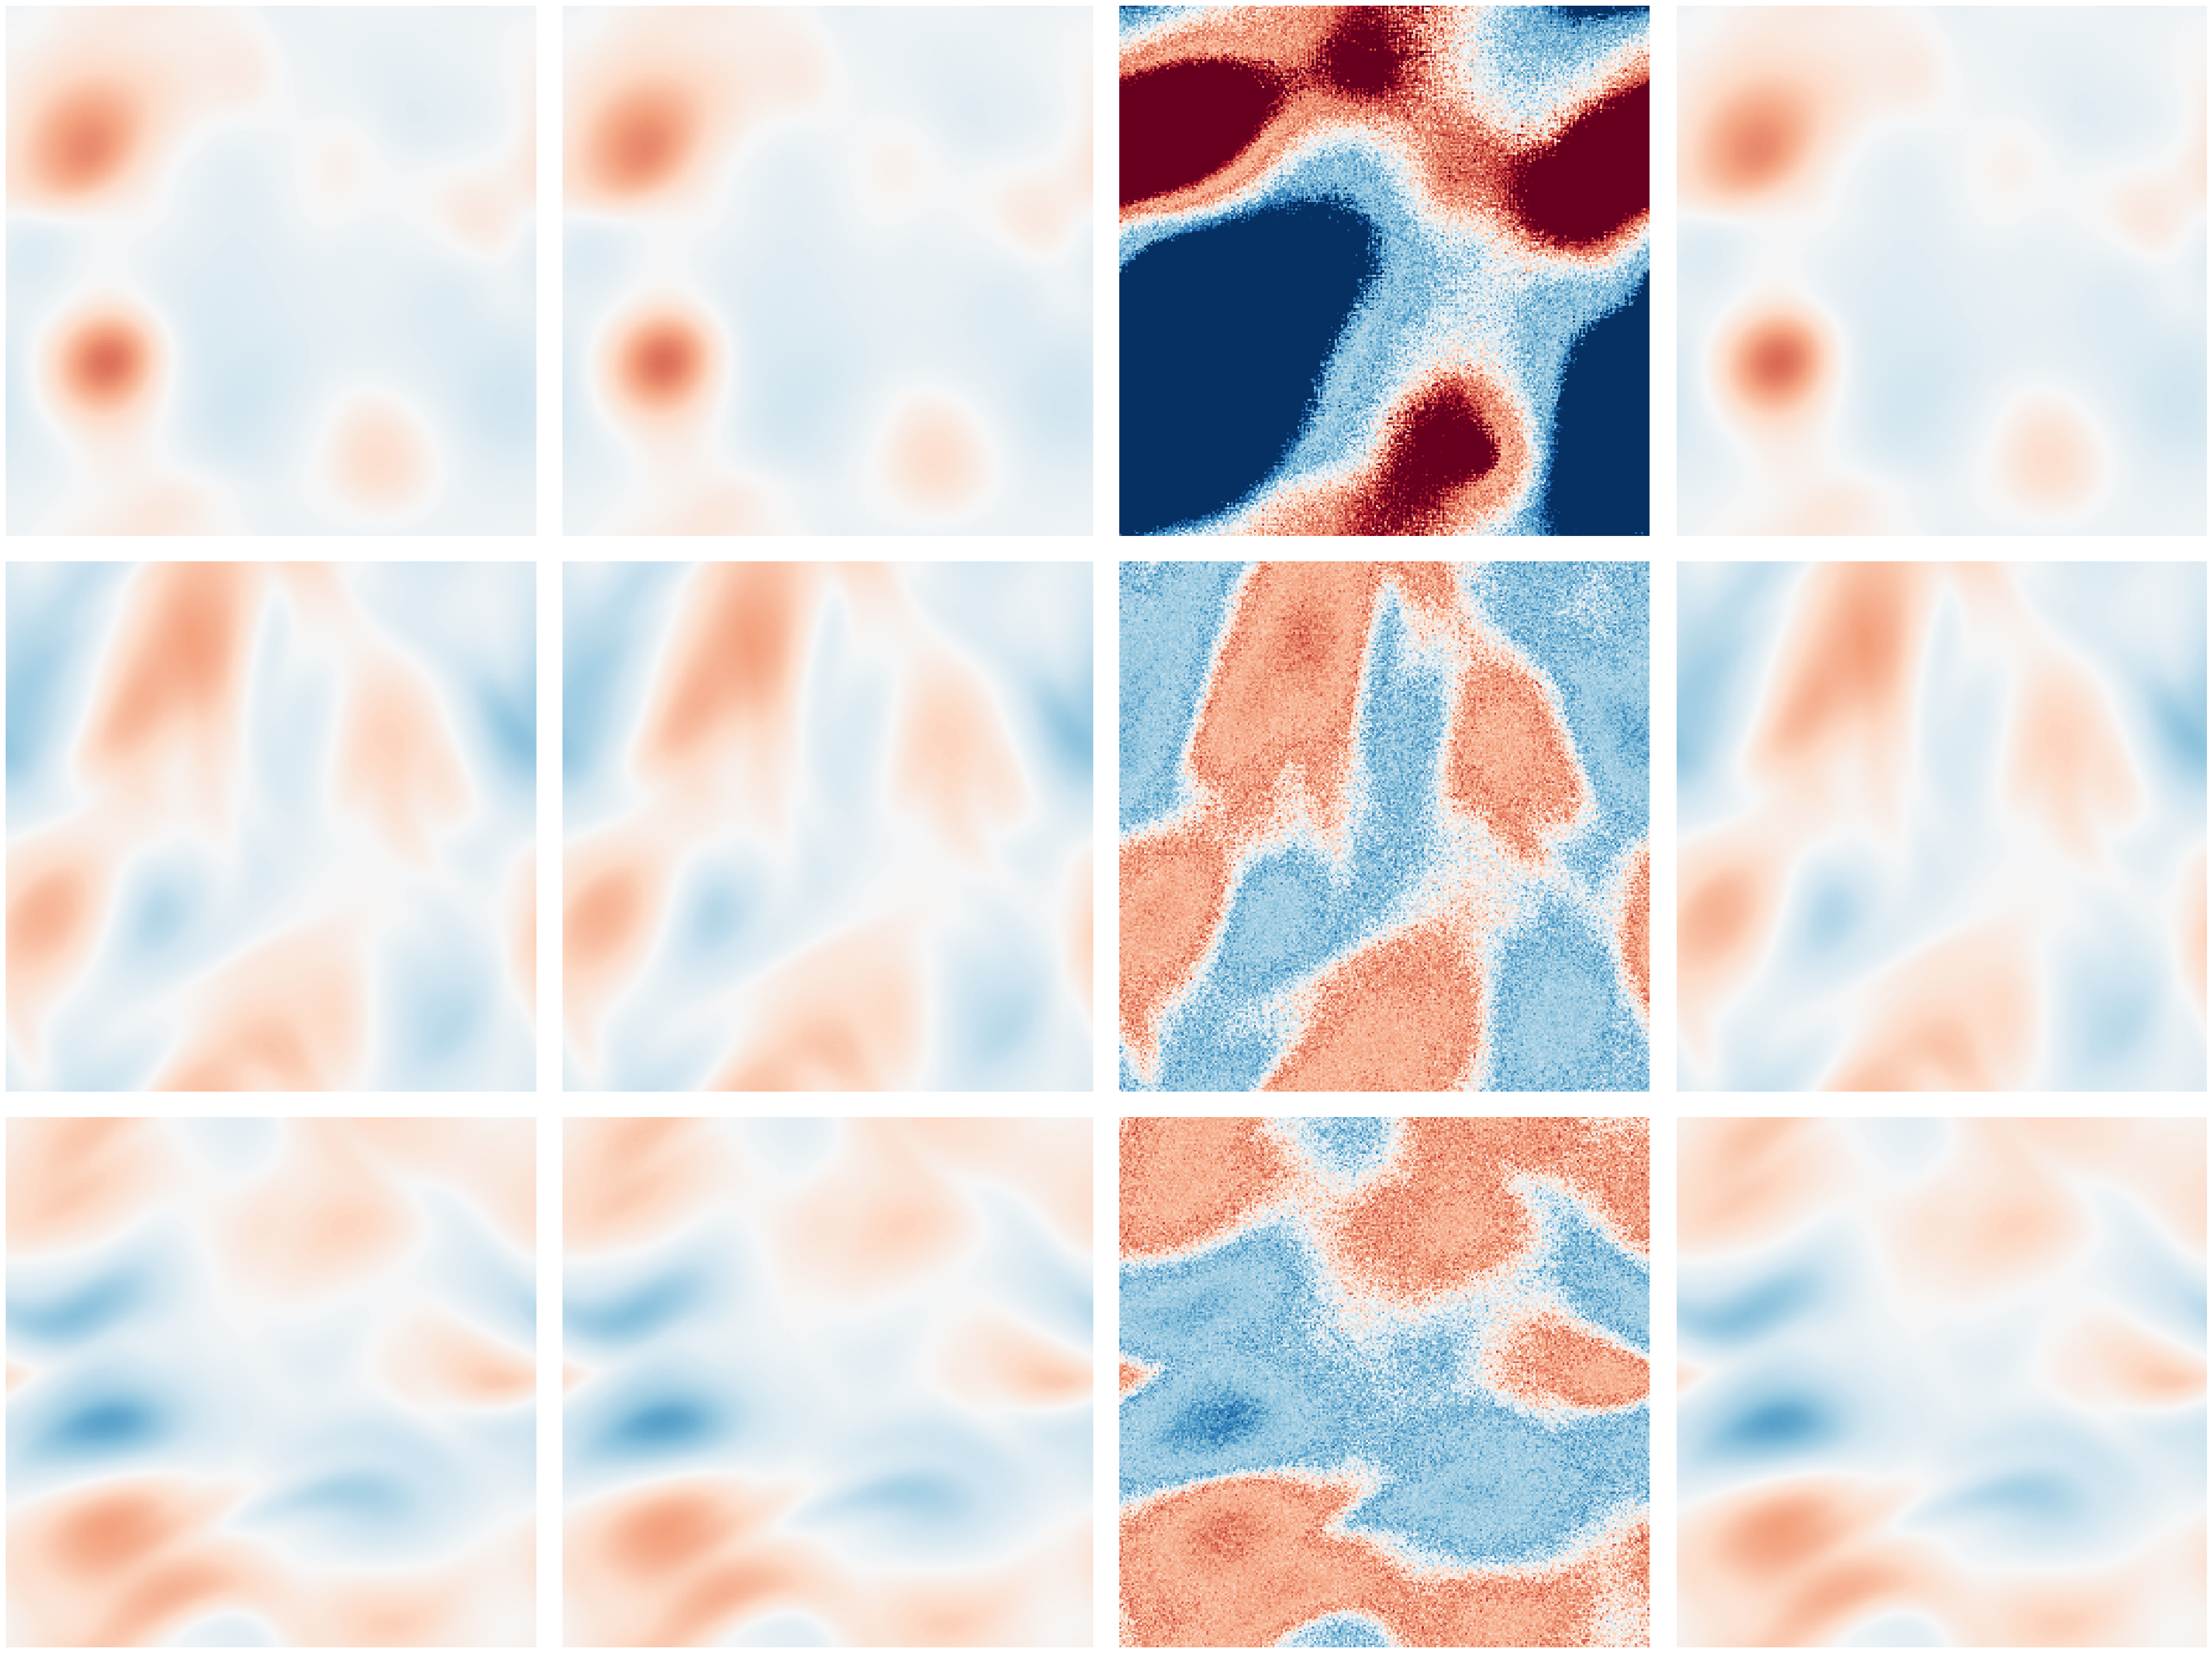

In [13]:
show_error = False
g = (
    sns.FacetGrid(
        data=pd.DataFrame({k: list(map(str, range(true_state.shape[0]))) for k in ['True', *cfgs]}).melt(var_name='Model', value_name='Value'),
        height=10,
        row='Value',
        col='Model',
    )
    .set_titles('')
)
v_min, v_max = get_cmap_bounds(show_error, same_cmap_for_trajectory_and_error=True)
v_absmax = max(map(abs, (v_min, v_max)))
for (row, col, hue), _ in g.facet_data():
    ax = g.axes[row, col]
    ax.set_axis_off()
    model_name = g.col_names[col]
    if model_name == 'True':
        data = true_state[row]
    else:
        data = cfgs[model_name]['trajectory'][row]
    if show_error:
        data = data - true_state[row]
    im_out = ax.imshow(data, cmap='RdBu', vmin=-v_absmax, vmax=v_absmax)
g.tight_layout()
# g.figure.subplots_adjust(right=.8)
# cbar_ax = g.figure.add_axes([0.85, 0.17, 0.02, 0.7])
# g.figure.colorbar(im_out, cax=cbar_ax)

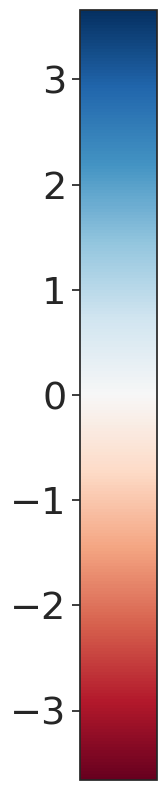

In [14]:
fig, ax = plt.subplots(figsize=(1, 10))
fig.colorbar(
    matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=-v_absmax, vmax=v_absmax), cmap='RdBu'),
    cax=ax,
    location='left',
)
title = 'Error' if show_error else 'Trajectory'
fig.savefig(f'{title}.colorbar.pdf', format='pdf', bbox_inches='tight', pad_inches=.03)

In [15]:
plots.save_all_subfigures(g, title, renaming=dict(alt_ids[['alt_id', 'label']].iter_rows()))